<a href="https://colab.research.google.com/github/willystw/fastai-learning/blob/main/hr-analytics/HR_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solving [HR Analytics Job Change](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists) using Neural Network and Google Colab

In [1]:
#hide
!pip install -Uqq fastbook kaggle
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.5 MB/s 
     |████████████████████████████████| 189 kB 41.3 MB/s 
     |████████████████████████████████| 1.2 MB 26.2 MB/s 
     |████████████████████████████████| 46 kB 1.9 MB/s 
     |████████████████████████████████| 56 kB 2.6 MB/s 
     |████████████████████████████████| 51 kB 207 kB/s 
Mounted at /content/gdrive


Insert kaggle.json before proceed to the next step

In [2]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [3]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

In [4]:
!rm -r ~/hr-analytics
!mkdir ~/hr-analytics

rm: cannot remove '/root/hr-analytics': No such file or directory


In [5]:
#Download dataset
api.dataset_download_cli(dataset='arashnic/hr-analytics-job-change-of-data-scientists',
                         path='hr-analytics',
                         unzip=True,
                         force=True)

100%|██████████| 295k/295k [00:00<00:00, 52.3MB/s]

In [6]:
train_ds = pd.read_csv('hr-analytics/aug_train.csv', low_memory=False)
test_ds = pd.read_csv('hr-analytics/aug_test.csv')

In [7]:
train_ds.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [8]:
dep_var = 'target'

## Baseline

In [9]:
train_ds[dep_var].value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

What is the probability if I return false in every training data ? This data will be used as baseline

In [10]:
14381 / (14381 +  4777)

0.7506524689424784

This means 75% of accuracy

## Using Neural Network

In [11]:
cont,cat = cont_cat_split(train_ds, max_card=2000, dep_var=dep_var)
cont, cat

(['enrollee_id', 'city_development_index'],
 ['city',
  'gender',
  'relevent_experience',
  'enrolled_university',
  'education_level',
  'major_discipline',
  'experience',
  'company_size',
  'company_type',
  'last_new_job',
  'training_hours'])

In [12]:
procs = [Categorify, FillMissing, Normalize]
tabular_data = TabularPandas(train_ds, 
                      procs, 
                      cat, 
                      cont,
                      splits=RandomSplitter(valid_pct=0.2)(range_of(train_ds)), 
                      y_names=dep_var,
                      y_block = CategoryBlock )

In [13]:
dls = tabular_data.dataloaders(128)
dls.show_batch()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,enrollee_id,city_development_index,target
0,city_67,Male,Has relevent experience,no_enrollment,#na#,#na#,>20,5000-9999,Public Sector,>4,17,10930.000178,0.855,0.0
1,city_136,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,50-99,#na#,1,9,26745.000566,0.897,0.0
2,city_16,#na#,Has relevent experience,no_enrollment,Graduate,STEM,>20,10/49,Pvt Ltd,>4,282,7099.000463,0.910,0.0
3,city_21,Male,Has relevent experience,Full time course,Masters,STEM,1,50-99,Pvt Ltd,1,22,18506.000031,0.624,0.0
4,city_21,Male,Has relevent experience,no_enrollment,Graduate,STEM,6,<10,Funded Startup,1,88,21691.999776,0.624,0.0
5,city_103,#na#,No relevent experience,Full time course,Graduate,STEM,7,#na#,#na#,#na#,47,20226.000143,0.920,0.0
6,city_21,Male,No relevent experience,Full time course,Graduate,STEM,<1,#na#,#na#,never,64,33287.000082,0.624,1.0
7,city_136,#na#,Has relevent experience,no_enrollment,Masters,STEM,4,5000-9999,Public Sector,1,130,15748.999965,0.897,0.0
8,city_16,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,50-99,Pvt Ltd,1,70,19219.000013,0.910,0.0
9,city_70,Male,No relevent experience,no_enrollment,Graduate,STEM,6,#na#,#na#,never,23,8542.999991,0.698,1.0


SuggestedLRs(valley=0.001737800776027143)

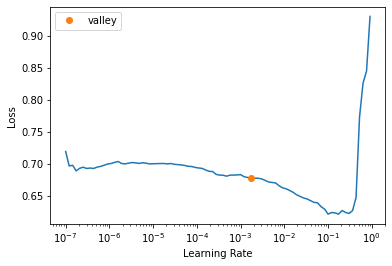

In [14]:
learn = tabular_learner(dls,
                        metrics=[accuracy, RocAucBinary()],
                        loss_func = CrossEntropyLossFlat())
learn.lr_find()

In [15]:
learn.fit_one_cycle(2, 3e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.479046,0.450362,0.793004,0.779131,00:02
1,0.445705,0.443089,0.791438,0.776980,00:02


SuggestedLRs(valley=4.365158383734524e-05)

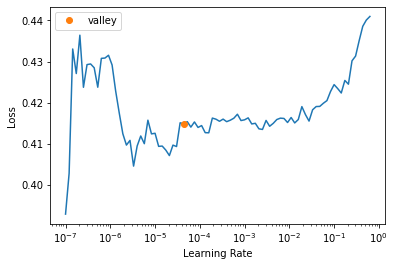

In [16]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(5, 1e-4, wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.415212,0.444184,0.790133,0.777041,00:02
1,0.412002,0.445441,0.791960,0.777211,00:02
2,0.411281,0.445876,0.791177,0.777127,00:02
3,0.415505,0.445661,0.790916,0.777091,00:02
4,0.412568,0.446196,0.793265,0.777071,00:02


## Prediction

In [20]:
test_dl = learn.dls.test_dl(test_ds)
predictions = learn.get_preds(dl=test_dl)

In [21]:
predictions, predictions[0][:,1]

((tensor([[0.8472, 0.1528],
          [0.6195, 0.3805],
          [0.4394, 0.5606],
          ...,
          [0.9353, 0.0647],
          [0.9241, 0.0759],
          [0.8939, 0.1061]]), None),
 tensor([0.1528, 0.3805, 0.5606,  ..., 0.0647, 0.0759, 0.1061]))

In [22]:
result = pd.DataFrame({'enrollee_id': test_ds['enrollee_id'], 'target': predictions[0][:,1]})
result.head()

,enrollee_id,target
0,32403,0.152772
1,9858,0.380494
2,31806,0.560640
3,27385,0.049314
4,27724,0.048169


In [23]:
result.to_csv('result.csv', index=False)